## Fig. 2 Circulation around idealized Astoria and Barkley canyons


In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.gridspec as gspec
import matplotlib as mpl
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import xarray as xr
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

In [2]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density using a linear equation of state.
    
    INPUT:
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be at least 2D arrays in coordinate order (..., Y , X ) 
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [...,ny,nx]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T[...,:,:]) + beta*(S[...,:,:]))
    return rho

def call_unstag(t):
    UU,VV = rout.unstagger(state.U.isel(T=t, Xp1=slice(0,361)),state.V.isel(T=t, X=slice(0,360)))
    return(UU,VV)


def call_rho(state,t,yslice,xslice):
    T = state.Temp.isel(T=t,Y=yslice,X=xslice)
    S = state.S.isel(T=t,Y=yslice,X=xslice)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 

def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcAreaFunc(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    shape = np.shape(Tr)
    ConcArea = np.empty((shape[0],shape[2],shape[3]))
    Conc = np.empty((shape[0],shape[2],shape[3]))
    ConcFiltered = np.empty((shape[0],shape[2],shape[3]))
    Area = np.empty((shape[0],shape[2],shape[3]))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    print(np.shape(BottomInd))
    for tt in range(shape[0]):
        #print(tt)
        for j in range(shape[3]):
            for i in range(shape[2]):
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                if TrBottom > 0.0:
                    ConcArea[tt,i,j] = TrBottom*ra[i,j]
                    Conc[tt,i,j] = TrBottom
                    Area[tt,i,j] = ra[i,j]
                else:
                    ConcArea[tt,i,j] = np.NaN
                    Conc[tt,i,j] = np.NaN
                    Area[tt,i,j] = np.NaN
                    
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    print(np.shape(ConcArea))
    
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (np.ma.masked_array(ConcArea, mask=maskShelf),
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            np.ma.masked_array(Area, mask=maskShelf),
           )

In [66]:
def U_vel(ax,UU,yslice, xind, grid, MaskC):
    '''UU is the mean u field, unstaggered, size (nz,ny,nx)
       ax is the corresponding handle for the axis'''
    umin = -0.6
    umax = 0.6
    csU = np.linspace(umin,umax,num=20)
    csU2 = np.linspace(umin,umax,num=10)
    
    Uplot = np.ma.array(UU.isel(Xp1=xind,Y=yslice).data,mask=MaskC[:,yslice,xind])
    mesh = ax.contourf(grid.Y[yslice]/1000,grid.Z[:],Uplot[:,:]*100.0,csU*100,cmap=cmo.cm.balance)
    
    cbar_ax = f.add_axes([0.65, 0.4, 0.015, 0.13])
    cb=f.colorbar(mesh, cax=cbar_ax,ticks=[-60,-40,-20,-0,20,40,60],format='%d')
    cb.ax.yaxis.set_tick_params(pad=2)

    ax.set_facecolor('#a99582')
    ax.text(0.5,0.1,'u / cm s$^{-1}$',transform=ax.transAxes,weight='semibold')
    #ax.set_xlabel('Alongshore distance (km)',labelpad=0.0)
    ax.tick_params(axis='x', pad=1.2)
    ax.tick_params(axis='y', pad=1.2)
    ax.yaxis.tick_right()
def V_vel(ax,VV,xslice, yind, grid, MaskC, state):
    '''VV is the mean v field, unstaggered, size (nz,ny,nx)
       ax is the corresponding handle for the axis'''
    umin = -0.4
    umax = 0.4
    csU = np.linspace(umin,umax,num=20)
    csU2 = np.linspace(umin,umax,num=10)
    
    density = call_rho(state,slice(6,10),yind,xslice)
    cs_dens = [20.7,20.8,20.9,21.0,21.1,21.2,21.3,21.4,21.5,21.6,21.7,21.8,21.9,22.0,22.1,22.2]

    Uplot = np.ma.array(VV.isel(X=xslice,Yp1=yind).data,mask=MaskC[:,yind,xslice])
    mesh = ax.contourf(grid.X[xslice]/1000,grid.Z[:75],Uplot[:75,:]*100.0,csU*100,cmap=cmo.cm.balance)
    
    CS = ax.contour(grid.X[xslice]/1000,grid.Z[:75],
                     np.ma.array(np.nanmean(density[:,:75,:].data-1000,axis=0),mask=MaskC[:75,yind,xslice]),
                     cs_dens,colors='0.3',linewidths=[0.75] )
    plt.clabel(CS,[cs_dens[1],cs_dens[3]],inline=True, fmt='%.1f',inline_spacing=1)
    
    cbar_ax = f.add_axes([0.45, 0.4, 0.015, 0.13])
    cb=f.colorbar(mesh, cax=cbar_ax,ticks=[-40,-20,0,20,40],format='%d')
    cb.ax.yaxis.set_tick_params(pad=2)

    ax.set_facecolor('#a99582')
    ax.text(0.5,0.1,'v / cm s$^{-1}$',transform=ax.transAxes,weight='semibold')
    #ax.set_xlabel('Alongshore distance (km)',labelpad=0.0)
    ax.tick_params(axis='x', pad=1.2)
    ax.tick_params(axis='y', pad=1.2)
    ax.yaxis.tick_right()
def W_vel(ax,WW,UU,VV, yslice, xslice,zind, grid, MaskC, sbdepth=-150):
    '''WW is the mean w field, unstaggered, size (nz,ny,nx)
       ax is the corresponding handle for the axis'''
    umin = -0.005
    umax = 0.005
    csU = np.linspace(umin,umax,num=20)
    csU2 = np.linspace(umin,umax,num=10)
    
    Uplot = np.ma.array(WW.isel(X=xslice,Y=yslice,Zl=zind).data,mask=MaskC[zind,yslice,xslice])
    Uquiv = np.ma.array(UU.isel(Xp1=xslice,Y=yslice,Z=zind).data,mask=MaskC[zind,yslice,xslice])
    Vquiv = np.ma.array(VV.isel(X=xslice,Yp1=yslice,Z=zind).data,mask=MaskC[zind,yslice,xslice])
    
    mesh = ax.contourf(grid.X[xslice]/1000,grid.Y[yslice]/1000,Uplot[:,:]*1000.0,csU*1000,cmap=cmo.cm.balance)
    ax.contour(grid.X[xslice]/1000,grid.Y[yslice]/1000,grid.Depth[yslice,xslice],[sbdepth], colors='0.5')
    Q = ax.quiver(grid.X[xslice][::10]/1000,grid.Y[yslice][::10]/1000,
                  Uquiv[::10,::10],Vquiv[::10,::10], color='k',
                  angles='xy', scale_units='xy', scale=0.1, width=0.005, headwidth=4)
    qk = ax.quiverkey(Q, 0.1, 0.95, 0.1, r'$50 \frac{cm}{s}$',
                      labelpos='S',
                      coordinates='axes',
                      fontproperties={'weight': 'bold'})
    cbar_ax = f.add_axes([0.25, 0.46, 0.015, 0.13])
    cb=f.colorbar(mesh, cax=cbar_ax,ticks=[-5,-2.5,0,2.5,5],format='%1.1f')
    cb.ax.yaxis.set_tick_params(pad=2)

    ax.set_facecolor('#a99582')
    ax.text(0.3,0.9,'w / mm s$^{-1}$',transform=ax.transAxes,weight='semibold')
    #ax.set_xlabel('Alongshore distance (km)',labelpad=0.0)
    ax.tick_params(axis='x', pad=1.2)
    ax.tick_params(axis='y', pad=1.2)
    ax.set_aspect(1)
    
def density_cs(ax,tslice,yslice,xslice,state,grid,ptracers,MaskC):
    
    #rho_min = 1020.4-1000
    #rho_max = 1022.4-1000 
    #density = call_rho(tslice,yslice,xslice)
    #csU2 = np.linspace(rho_min,rho_max,num=11)
    
    csU = np.linspace(2.1,16.5,25)  
    rho_min = 1020.7-1000
    rho_max = 1021.9-1000 
    density = call_rho(state,tslice,yslice,xslice)
    csU2 = [20.7,20.8,20.9,21.0,21.1,21.2,21.3,21.4,21.5,21.6,21.7]

    tr_min = 0
    tr_max = 22
    csU = np.linspace(tr_min,tr_max,num=20)
    
    mesh=ax.contourf(grid.Y[yslice]/1000,grid.Z[:56],
                      np.ma.array(np.nanmean(ptracers.Tr01[tslice,:56,yslice,xslice].data,axis=0),
                                  mask=MaskC[:56,yslice,xslice]),
                      csU,cmap=cmo.cm.dense)
    
    cbar_ax = f.add_axes([0.85, 0.4, 0.015, 0.13])
    cb=f.colorbar(mesh, cax=cbar_ax,ticks=[0,3,6,9,12,15,18,21],format='%d')
    cb.ax.yaxis.set_tick_params(pad=2)

    CS = ax.contour(grid.Y[yslice]/1000,grid.Z[:56],
                     np.ma.array(np.nanmean(density[:,:56,:].data-1000,axis=0),mask=MaskC[:56,yslice,xslice]),
                     csU2,colors='k',linewidths=[0.75] )
    ax.yaxis.tick_right()
    #manual_locations = [(45, -50), (45, -150), (45, -250),(45,-350)]
    plt.clabel(CS,[csU2[1],csU2[3]],inline=True, fmt='%.1f',inline_spacing=1)
    
    ax.set_facecolor('#a99582')
    ax.text(0.2,0.1,r'C / $\mu$M',transform=ax.transAxes,weight='semibold')
    ax.tick_params(axis='x', pad=1.2)
    ax.tick_params(axis='y', pad=1.2)
    #ax.text(0.95,0.1,r'(a)',transform=ax.transAxes)
   
 # Incoming U
def inc_U(ax,UU,yslice, color='k', label='Astoria'):
    ax.axvline(4,color='0.8', linestyle=':', linewidth=2)
    Uplot=np.nanmean(np.nanmean(UU.isel(Y=yslice).data,axis=1), axis=1)
    ax.plot(np.arange(19)/2.0,Uplot,color=color, label=label, linewidth=2)
    plt.yticks( [0.00,0.10,0.20,0.30], ('0.0', '0.1', '0.2', '0.3', '0.4') )      
    ax.set_ylabel(r'$U$ / ms$^{-1}$',labelpad=0.3)
    ax.set_xlabel('Days',labelpad=0.3)
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_xlim([0,9])
    
def water_transports(ax,dfcan):
    ax.axhline(0, color='gold')
    ax.plot(np.arange(19)/2.0,(dfcan.Vert_water_trans_sb)/1E4,':',color='k',label = 'LID', linewidth=2)
    ax.plot(np.arange(19)/2.0,(dfcan.CS1_water_trans)/1E4,color='0.4',label = 'CS1', linewidth=2)
    ax.plot(np.arange(19)/2.0,(dfcan.CS2_water_trans)/1E4,color='0.6',label = 'CS2', linewidth=2)
    ax.plot(np.arange(19)/2.0,(dfcan.CS3_water_trans)/1E4,color='0.8',label = 'CS3', linewidth=2)
    ax.plot(np.arange(19)/2.0,(dfcan.CS4_water_trans)/1E4,':',color='0.5',label= 'CS4', linewidth=2)
    ax.plot(np.arange(19)/2.0,(dfcan.CS5_water_trans)/1E4,color='k',label = 'CS5', linewidth=2)
    ax.plot(np.arange(19)/2.0,(dfcan.CS6_water_trans)/1E4,'--',color='k',label = 'CS6', linewidth=2)
 
    total = (dfcan.CS1_water_trans +
              dfcan.CS2_water_trans +
              dfcan.CS3_water_trans +
              dfcan.CS4_water_trans +
              dfcan.CS5_water_trans +
              dfcan.CS6_water_trans +
              dfcan.Vert_water_trans_sb)

    ax.plot(np.arange(19)/2.0,total/1E4,'--',color='mediumturquoise',label = 'Total', linewidth=2)
    ax.set_xlabel('Days',labelpad=0.5)
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    #ax.set_ylim(-25,15)

In [4]:
# Isopycnal countours and tracer contourf alongshore
def Plot2(ax,tslice,yslice,xslice):
    
    #rho_min = 1020.4-1000.0
    #rho_max = 1022.4-1000.0 # 1022.4 if y=230,1021.4 if y=260
    #density = call_rho(tslice,yslice,xslice)
    #csU2 = np.linspace(rho_min,rho_max,num=11)
    
    csU = np.linspace(2.1,16.5,25)  
    rho_min = 1020.7-1000
    rho_max = 1021.9-1000 
    density = call_rho(tslice,yslice,xslice)
    csU2 = [20.7,20.8,20.9,21.0,21.1,21.2,21.3,21.4,21.5,21.6,21.7,21.8,21.9,22,22.1,22.2]

    tr_min = 0
    tr_max = 22 
    csU = np.linspace(tr_min,tr_max,num=22)
    
    mesh=ax.contourf(grid.X[xslice]/1000,grid.Z[:56],
                      np.ma.array(np.nanmean(ptracers.Tr1[tslice,:56,yslice,xslice].data,axis=0),
                                  mask=MaskC[:56,yind,xslice]),
                      csU,cmap=cmo.cm.delta)
    
    cbar_ax = f.add_axes([0.907, 0.722, 0.015, 0.158])
    cb=f.colorbar(mesh, cax=cbar_ax,ticks=[0,3,6,9,12,15,18,21],format='%d')
    cb.ax.yaxis.set_tick_params(pad=2)

    CS = ax.contour(grid.X[xslice]/1000,grid.Z[:56],
                     np.ma.array(np.nanmean(density[:,:56,:].data-1000,axis=0),mask=MaskC[:56,yslice,xslice]),
                     csU2,colors='k',linewidths=[0.75] )
   
    #manual_locations = [(40, -50), (80, -150), (80, -250),(70,-350)]
    plt.clabel(CS,[csU2[2],csU2[4],csU2[10],csU2[15]],inline=True, fmt='%.1f',inline_spacing=1)
    ax.set_facecolor('#a99582')
    ax.text(0.85,0.1,r'C / $\mu$M',transform=ax.transAxes,weight='semibold')
    ax.text(0.02,0.1,r'(b)',transform=ax.transAxes,weight='semibold')
    
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)


In [5]:
# speed contourf and velocity quiver
def Plot3(ax,UU,VV,zind,xslice,yslice,x_qslice,y_qslice):
    
    Uplot=np.ma.array(UU.isel(Z=zind,Xp1=xslice,Y=yslice).data,mask=MaskC[zind,yslice,xslice])
    Vplot=np.ma.array(VV.isel(Z=zind,X=xslice,Yp1=yslice).data,mask=MaskC[zind,yslice,xslice])
    
    spd = np.sqrt(Uplot**2+Vplot**2)
    
    smin = np.min(spd*100)
    smax= np.max(spd*100)
    
    csU = np.linspace(smin,smax,num=20)
    
    mesh=ax.contourf(grid.X[xslice]/1000,grid.Y[yslice]/1000,spd[:,:]*100,csU,cmap=cmo.cm.haline_r)
    
    cbar_ax = f.add_axes([0.907, 0.343, 0.015, 0.162])
    cb=f.colorbar(mesh, cax=cbar_ax,ticks=[0,5,10,15,20,25,30,35,40,45],format='%d')
    cb.ax.yaxis.set_tick_params(pad=2)
    
    
    Q = ax.quiver(grid.X[x_qslice]/1000,
                  grid.Y[y_qslice]/1000, 
                  Uplot[::10,::10], 
                 Vplot[::10,::10], color=(255/255,69/255,0/255),
                  angles='xy', scale_units='xy', scale=0.05, width=0.005, headwidth=4)
    qk = ax.quiverkey(Q, 0.1, 0.95, 0.5, r'$50 \frac{cm}{s}$',
                   labelpos='S',
                   coordinates='axes',
                   fontproperties={'weight': 'bold'})
     
    SB = ax.contour(grid.X[xslice]/1000,grid.Y[yslice]/1000,
                     grid.Depth[yslice,xslice],
                    [150.0],
                    colors='0.8',linewidths=[0.75] )
    ax.set_facecolor('#a99582')
    ax.set_ylabel('CS distance / km',labelpad=0.0)
    ax.text(0.63,0.85,' speed / cm s$^{-1}$  (f)',transform=ax.transAxes,weight='semibold')
    #ax.text(0.9,0.9,' (f)',transform=ax.transAxes)
    ax.set_aspect(1)
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)


In [6]:
# Cross-shelf U
def Plot4(ax,UU,xind,yslice):
    
    umin = -50
    umax= 50
    
    Uplot=np.ma.array(UU.isel(Xp1=xind,Y=yslice).data,mask=MaskExpand[14,:,yslice,xind])
    csU = np.linspace(umin,umax,num=20)
    csU2 = np.linspace(umin,umax,num=10)
    
    mesh=ax.contourf(grid.Y[yslice]/1000,grid.Z[:56],Uplot[:56,:]*100,csU,cmap=cmo.cm.balance)
    
    cbar_ax = f.add_axes([0.42, 0.537, 0.015, 0.158])
    cb=f.colorbar(mesh, cax=cbar_ax,orientation='vertical',ticks=[-50,-25,0,25,50],format='%d')
    cb.ax.yaxis.set_tick_params(pad=2)
    
    ax.plot(grid.Y[230:251]/1000,(grid.RC[20].data)*np.ones(np.shape(grid.Y[230:251])),color='0.5')
    ax.plot(grid.Y[230:251]/1000,(grid.RC[16].data)*np.ones(np.shape(grid.Y[230:251])),color='0.5')
    ax.plot(((grid.Y[230]/1000).data)*np.ones(np.shape(grid.RC[16:21])),grid.RC[16:21],color='0.5')
    ax.plot(((grid.Y[250]/1000).data)*np.ones(np.shape(grid.RC[16:21])),grid.RC[16:21],color='0.5')

    ax.set_facecolor('#a99582')
    #ax.text(0.8,0.1,'u (cm s$^{-1}$)',transform=ax.transAxes)
    ax.text(0.59,0.1,'u / cm s$^{-1}$  (c)',transform=ax.transAxes,weight='semibold')
    
    ax.set_xlabel('CS distance / km',labelpad=0.01)
    ax.set_ylabel('Depth / m',labelpad=0.0)
    
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)


In [7]:
##### Incoming U
def Plot5(ax,UU,xind,yslice,zslice,tslice):
    ax.axvline(4,color='0.8', linestyle=':', linewidth=2)
    Uplot=np.nanmean(np.nanmean(np.ma.array(UU.isel(Y=yslice).data,
                                            mask=MaskExpand[tslice,zslice,yslice,xind]),axis=1),axis=1)
    ax.plot(np.arange(19)/2.0,Uplot,color='0.4')
    plt.yticks( [0.00,0.10,0.20,0.30], ('0.0', '0.1', '0.2', '0.3', '0.4') )      
    ax.set_ylabel(r'$U$ / ms$^{-1}$',labelpad=0.3)
    #ax.set_xlabel('Days',labelpad=0.3)
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.text(0.9,0.1,'(e)',transform=ax.transAxes,weight='semibold')
    ax.set_aspect(10)
    ax.set_xlim([0,9])

In [8]:
# Isopycnal countours and tracer contourf cross-shore
def Plot6(ax,tslice,yslice,xslice):
    
    #rho_min = 1020.4-1000
    #rho_max = 1022.4-1000 
    #density = call_rho(tslice,yslice,xslice)
    #csU2 = np.linspace(rho_min,rho_max,num=11)
    
    csU = np.linspace(2.1,16.5,25)  
    rho_min = 1020.7-1000
    rho_max = 1021.9-1000 
    density = call_rho(tslice,yslice,xslice)
    csU2 = [20.7,20.8,20.9,21.0,21.1,21.2,21.3,21.4,21.5,21.6,21.7,21.8,21.9,22,22.1,22.2,22.3]

    tr_min = 0
    tr_max = 22
    csU = np.linspace(tr_min,tr_max,num=20)
    
    mesh=ax.contourf(grid.Y[yslice]/1000,grid.Z[:56],
                      np.ma.array(np.nanmean(ptracers.Tr1[tslice,:56,yslice,xslice].data,axis=0),
                                  mask=MaskC[:56,yslice,xslice]),
                      csU,cmap=cmo.cm.delta)
    
    cbar_ax = f.add_axes([0.42, 0.722, 0.015, 0.158])
    cb=f.colorbar(mesh, cax=cbar_ax,ticks=[0,3,6,9,12,15,18,21],format='%d')
    cb.ax.yaxis.set_tick_params(pad=2)

    CS = ax.contour(grid.Y[yslice]/1000,grid.Z[:56],
                     np.ma.array(np.nanmean(density[:,:56,:].data-1000,axis=0),mask=MaskC[:56,yslice,xslice]),
                     csU2,colors='k',linewidths=[0.75] )
    
    #manual_locations = [(45, -50), (45, -150), (45, -250),(45,-350)]
    plt.clabel(CS,[csU2[2],csU2[7],csU2[11],csU2[16]],inline=True, fmt='%.1f',inline_spacing=1)
    
    ax.set_facecolor('#a99582')
    ax.text(0.66,0.1,r'C / $\mu$M    (a)',transform=ax.transAxes,weight='semibold')
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    #ax.text(0.95,0.1,r'(a)',transform=ax.transAxes)
    ax.set_ylabel('Depth / m',labelpad=0.0)

In [9]:
# BAC colormap
def Plot8(ax,ConcFilt,tslice,xslice,yslice):
    
    BAC = np.nanmean(ConcFilt[tslice,yslice,xslice],axis=0)
    
    maxCM = np.max(BAC)
    minCM = np.min(BAC)
    
    mesh = ax.contourf(grid.X[xslice]/1000,grid.Y[yslice]/1000,BAC,21, 
                      vmax=maxCM, 
                      vmin=minCM,
                      cmap=cmo.cm.matter)
    
    cbar_ax = f.add_axes([0.907, 0.15, 0.015, 0.15])
    cb=f.colorbar(mesh, cax=cbar_ax,ticks=[2.2,3.2,4.2,5.2,6.2,7.2,8.2,9.2,10.2],format='%.1f')
    cb.ax.yaxis.set_tick_params(pad=2)
   
    ax.set_facecolor('#a99582')
    
    ax.text(0.80,0.85,'BC / $\mu$M',transform=ax.transAxes,weight='semibold')
    SB = ax.contour(grid.X[xslice]/1000,grid.Y[yslice]/1000,
                     grid.Depth[yslice,xslice],
                    [150.0],
                    colors='0.1',linewidths=[0.75] )
    
    ax.plot([grid.X[120]/1000,grid.X[120]/1000],[grid.Y[227]/1000,grid.Y[315]/1000], '-', color='yellow')
    ax.plot([grid.X[120]/1000,grid.X[463]/1000],[grid.Y[315]/1000,grid.Y[315]/1000], '-', color='yellow')
    ax.plot([grid.X[463]/1000,grid.X[463]/1000],[grid.Y[315]/1000,grid.Y[227]/1000], '-', color='yellow')
    ax.plot([grid.X[463]/1000,grid.X[120]/1000],[grid.Y[227]/1000,grid.Y[227]/1000], '-', color='yellow')
   
    ax.set_xlabel('Alongshelf distance / km',labelpad=0.3)
    ax.set_ylabel('CS distance / km',labelpad=0.3)
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    ax.text(0.02,0.85,'(h)',transform=ax.transAxes,weight='semibold')
    ax.set_xlim(grid.X[115]/1000,grid.X[464]/1000)
  

In [10]:
  
# Mean BAC
def Plot9(ax,ConcArea,Area,tslice,xslice,yslice):
    
    ax.axvline(4,color='0.8', linestyle=':', linewidth=2)
    AA = np.sum(np.sum(Area[tslice,yslice,xslice],axis=1),axis=1)
    BAC = (np.nansum(np.nansum(ConcArea[tslice,yslice,xslice],axis=1),axis=1))/AA[0]
           
    ax.plot(np.arange(19)/2.0,BAC,color='0.4', linewidth=2)
    
    plt.yticks( [5.0,6.0,7.0,8.0], ('5.0', '6.0', '7.0', '8.0') )    
    ax.set_ylabel('BC / $\mu$M',labelpad=0.3)
    ax.set_xlabel('Days',labelpad=0.3)
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.text(0.9,0.1,'(g)',transform=ax.transAxes,weight='semibold')
    ax.set_aspect(1.2)
    ax.set_xlim([0,9])

In [42]:
# Grid, state and datasets for Astoria
grid_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'
gridA = xr.open_dataset(grid_file)

state_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc' 
stateA = xr.open_dataset(state_file)

ptrac_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc' 
ptracersA = xr.open_dataset(ptrac_file)

# Grid, state and tracers for Barkley
grid_file_b = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'
gridB = xr.open_dataset(grid_file_b)

state_file_b = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/stateGlob.nc' 
stateB = xr.open_dataset(state_file_b)

ptrac_file_b = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc' 
ptracersB = xr.open_dataset(ptrac_file_b)

fileWatA = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/water_CS_transports.nc')
fileWatB = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/water_CS_transports.nc')
dfwatA = xr.open_dataset(fileWatA)
dfwatB = xr.open_dataset(fileWatB)

#RhoRef = np.squeeze(rdmds('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/RhoRef'))
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

In [18]:
# General input
nx = 616
ny = 360
nz = 104
nt = 19 # t dimension size 

xslice=slice(0,360)
xp1_slice=slice(0,361)
yslice=slice(100,300)

# u contourf
xind = 180
yslice_u = slice(50,359)

# v contourf
yindA = 131
yindB = 131
xslice_v = slice(120,240)

# w contour
xslice_w = slice(120,240)
yslice_w = slice(120,240)

x_qslice = slice(60,300,10)
y_qslice = slice(150,280,10)

tslice = slice(6,10)

# incoming U
xind_U = 80
ysliceU_A = slice(130,230)
zsliceU_A = slice(14,19)
ysliceU_B = slice(130,160)
zsliceU_B = slice(29,34)

# 
yslice_umean = slice(150,267)
zslice_umean = slice(25,50)
tslice_umean = slice(0,19)

# plot 6
xslice_bac_calc = slice(0,463)
yslice_bac_2d = slice(225,350)
yslice_bac = slice(227,315)
xslice_bac = slice(118,463)

hFacmaskedA = np.ma.masked_values(gridA.HFacC.isel(X=xslice).data, 0)
MaskCA = np.ma.getmask(hFacmaskedA)

hFacmaskedB = np.ma.masked_values(gridB.HFacC.isel(X=xslice).data, 0)
MaskCB = np.ma.getmask(hFacmaskedB)



In [26]:
incUA,incVA = rout.unstagger(stateA.U.isel(Xp1=xind_U,Z=zsliceU_A),stateA.V.isel(X=xind_U,Z=zsliceU_A))

UUA,VVA = rout.unstagger(stateA.U.isel(T=tslice, Xp1=xp1_slice),stateA.V.isel(T=tslice, X=xslice))
UU_incA,VV_incA = rout.unstagger(stateA.U.isel(T=tslice_umean, Xp1=xp1_slice, Z=zslice_umean),
                               stateA.V.isel(T=tslice_umean, X=xslice, Z=zslice_umean))

In [27]:
incUB,incVB = rout.unstagger(stateB.U.isel(Xp1=xind_U,Z=zsliceU_B),stateB.V.isel(X=xind_U,Z=zsliceU_B))

UUB,VVB = rout.unstagger(stateB.U.isel(T=tslice, Xp1=xp1_slice),stateB.V.isel(T=tslice, X=xslice))
UU_incB,VV_incB = rout.unstagger(stateB.U.isel(T=tslice_umean, Xp1=xp1_slice, Z=zslice_umean),
                               stateB.V.isel(T=tslice_umean, X=xslice, Z=zslice_umean))

In [15]:
WWA = stateA.W.isel(T=tslice)
WWB = stateB.W.isel(T=tslice)


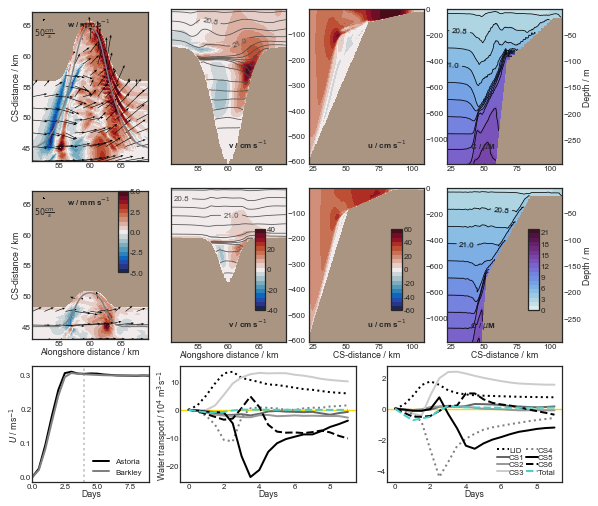

In [75]:
sns.set_context('paper')
sns.set_style('white')

plt.rcParams['font.size'] = 8.0

f = plt.figure(figsize = (9.5,8.7)) # 19.0cm = 7.4in, 115cm = 4.52in

gs = gspec.GridSpec(3, 1,hspace=0.17, height_ratios=[1,1,0.75])
gs0 = gspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[0],wspace=0.2)
gs1 = gspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[1], wspace=0.2)
gs2 = gspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[2],width_ratios=[1,1.5,1.5])

ax1 = plt.subplot(gs0[0])
W_vel(ax1,WWA.mean(dim='T'),UUA.mean(dim='T'),VVA.mean(dim='T'), yslice_w, xslice_w,25, gridA, MaskCA, sbdepth=150)
ax1.set_ylabel('CS-distance / km', labelpad=1)

ax5 = plt.subplot(gs1[0])
W_vel(ax5,WWB.mean(dim='T'),UUB.mean(dim='T'),VVB.mean(dim='T'), yslice_w, xslice_w,37, gridB, MaskCB, sbdepth=200)
ax5.set_xlabel('Alongshore distance / km', labelpad=1)
ax5.set_ylabel('CS-distance / km', labelpad=1)

ax2 = plt.subplot(gs0[1])
V_vel(ax2,VVA.mean(dim='T'),xslice_v,yindA, gridA, MaskCA,stateA)

ax6 = plt.subplot(gs1[1])
V_vel(ax6,VVB.mean(dim='T'),xslice_v,yindB, gridB, MaskCB, stateB)
ax6.set_xlabel('Alongshore distance / km', labelpad=1)

ax3 = plt.subplot(gs0[2])
U_vel(ax3,UUA.mean(dim='T'),yslice_u, xind, gridA, MaskCA) # isopyc alongshelf section

ax7 = plt.subplot(gs1[2])
U_vel(ax7,UUB.mean(dim='T'),yslice_u, xind, gridB, MaskCB) # isopyc alongshelf section
ax7.set_xlabel('CS-distance / km', labelpad=1)

ax4 = plt.subplot(gs0[3])
density_cs(ax4,tslice,yslice_u,xind, stateA,gridA,ptracersA,MaskCA) # speeds and quiver
ax4.yaxis.set_label_position("right")
ax4.set_ylabel('Depth / m', labelpad=1)

ax8 = plt.subplot(gs1[3])
density_cs(ax8,tslice,yslice_u,xind, stateB,gridB,ptracersB,MaskCB) # speeds and quiver
ax8.set_xlabel('CS-distance / km', labelpad=1)
ax8.yaxis.set_label_position("right")
ax8.set_ylabel('Depth / m', labelpad=1)

ax9 = plt.subplot(gs2[0])
inc_U(ax9,incUA,ysliceU_A, color='k', label='Astoria')
inc_U(ax9,incUB,ysliceU_B, color='0.5', label='Barkley')
ax9.legend(loc=0)

ax10 = plt.subplot(gs2[1])
water_transports(ax10,dfwatA)
ax10.set_ylabel('Water transport / 10$^{4}$ m$^3$s$^{-1}$',labelpad=-4)

ax11 = plt.subplot(gs2[2])
water_transports(ax11,dfwatB)
ax11.legend(loc=0, ncol=2,handletextpad=0 , labelspacing=0.1, handlelength=1.5, columnspacing=0.1)
#plt.tight_layout()

plt.savefig('circulation.eps',format='eps',bbox_inches='tight')
